# <p style="text-align: center;">Fashion MNIST Classification </p>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from tqdm import tqdm
from idx2numpy import convert_from_file
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from warnings import simplefilter

# ignore all warnings
# generated by logistic regression
simplefilter(action='ignore')
np.random.seed(42)

In [2]:
# displays images in n columns
def print_imgs(imgs, n):
    m=imgs.shape[0]
    for i in range(m):
        plt.subplot(m//n+1,n, i + 1)
        plt.imshow(imgs[i], interpolation="antialiased", cmap="binary")
        plt.axis('off')
    plt.show()

# Flattens and normalizes an array of images to make the images into 1D vectors
def flatten_imgs(imgs):
    shp =imgs.shape
    flat_imgs = imgs.reshape(-1, shp[1]*shp[2])
    return normalize(flat_imgs, norm= 'l2')

# makes k clusters
def clusters_and_labels(k, train_imgs, train_labels):
    #flatten images
    x_train = train_imgs
    # x_train = flatten_imgs(train_imgs)
    kmeans = KMeans(n_clusters=k, n_init="auto")

    # get the distances of each point to each cluster
    x_center_dists = kmeans.fit_transform(x_train)
    # index for the closest point to each cluster
    closest_idx = np.argmin(x_center_dists, axis=0)
    
    # This step is automated here, but if the labels 
    # are not available for the training images, can be done manually
    cluster_labels = train_labels[closest_idx]

    # get the distance of each point to it's closest cluster center
    x_cluster_dist = x_center_dists[np.arange(len(x_train)), kmeans.labels_]

    return kmeans, x_cluster_dist, closest_idx, cluster_labels

# Predicts which cluster the images in an array lie
def predict_labels(kmeans, cluster_labels, valid_imgs):
    # shp = valid_imgs.shape
    # x_valid = valid_imgs.reshape(-1, shp[1]*shp[2])
    x_valid=valid_imgs
    y_pred = kmeans.predict(x_valid)
    return cluster_labels[y_pred]

# propogates the cluster labels to clusest prop_frac * 100 percent of the points of the cluster
def propogate(kmeans,cluster_labels,x_train, x_cluster_dists, prop_frac = 0.05):

    # forms the list of clusters and sorts the points in them by their distance to the cluster center
    clusters = [[x for x,label in enumerate(kmeans.labels_) if label==i] for i in range(kmeans.n_clusters)]
    list(map(lambda x: x.sort(key = lambda y: x_cluster_dists[y]), clusters))

    # gets which points to label by their index
    to_prop = sum([x[0:(1+int(prop_frac*len(x)))] for x in clusters], [])
    to_prop.sort()

    # form new x and y data using those indices
    x_propogated = x_train[to_prop]
    y_propogated = cluster_labels[kmeans.labels_[to_prop]] # get the cluster of the point and then the label of the cluster

    return x_propogated, y_propogated

## Fashion MNIST

In [3]:
fashion_labels = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])

# loading the dataset
folder = "C:/Users/VARUN/Downloads/FMNIST/"
fashion_train_imgs = convert_from_file(folder + "train-images-idx3-ubyte")
fashion_train_labels = convert_from_file(folder + "train-labels-idx1-ubyte")
fashion_test_imgs = convert_from_file(folder + "t10k-images-idx3-ubyte")
fashion_test_labels = convert_from_file(folder + "t10k-labels-idx1-ubyte")

In [4]:
fashion_train_imgs, fashion_valid_imgs, fashion_train_labels, fashion_valid_labels = train_test_split(fashion_train_imgs, fashion_train_labels, test_size=0.1)

In [5]:
# dimension reduction using PCA
fashion_pca = PCA(50)
# flattening images and then fitting + transforming the images
fashion_reduced_imgs = fashion_pca.fit_transform(flatten_imgs(fashion_train_imgs))

In [6]:
# KMeans clustering
k=300
fashion_kmeans, fashion_cluster_dists, fashion_cluster_reps_idx, fashion_cluster_labels = clusters_and_labels(k, fashion_reduced_imgs, fashion_train_labels)

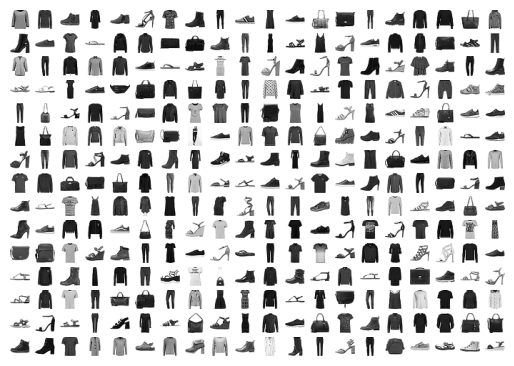

['Pullover' 'Pullover' 'Ankle Boot' 'Coat' 'Ankle Boot' 'Sandal' 'Shirt'
 'Ankle Boot' 'Trouser' 'Sneaker' 'Dress' 'Sneaker' 'Bag' 'Bag' 'Trouser'
 'Ankle Boot' 'Shirt' 'Pullover' 'Bag' 'Pullover' 'Ankle Boot' 'Sneaker'
 'T-shirt/top' 'Sandal' 'Coat' 'Shirt' 'Bag' 'Bag' 'Ankle Boot' 'Trouser'
 'Dress' 'Sandal' 'T-shirt/top' 'Sandal' 'Sneaker' 'Pullover' 'Coat' 'Bag'
 'Sandal' 'Trouser' 'Shirt' 'Trouser' 'Coat' 'Shirt' 'Coat' 'Sneaker'
 'Sandal' 'Sandal' 'Dress' 'Dress' 'Sandal' 'Ankle Boot' 'Sandal'
 'T-shirt/top' 'Ankle Boot' 'Sandal' 'Shirt' 'Ankle Boot' 'Trouser'
 'Ankle Boot' 'Sandal' 'Sandal' 'Dress' 'Sneaker' 'Bag' 'Bag' 'Coat' 'Bag'
 'Coat' 'Trouser' 'Pullover' 'Pullover' 'Sandal' 'T-shirt/top' 'Trouser'
 'Coat' 'Sandal' 'Trouser' 'Sandal' 'Sneaker' 'Trouser' 'Bag' 'Sandal'
 'Pullover' 'Sandal' 'Bag' 'Coat' 'T-shirt/top' 'T-shirt/top' 'Trouser'
 'Bag' 'T-shirt/top' 'Dress' 'Sandal' 'T-shirt/top' 'Sneaker' 'Sandal'
 'Bag' 'Sneaker' 'Sneaker' 'T-shirt/top' 'Bag' 'Pullover' 'Pullov

In [7]:
# These are the representative images of each cluster. The actual labels are also printed here to save time.
print_imgs(fashion_train_imgs[fashion_cluster_reps_idx], 20)
print(fashion_labels[fashion_cluster_labels])

In [8]:
# performance with just the clustering
y = predict_labels(fashion_kmeans, fashion_cluster_labels, fashion_pca.transform(flatten_imgs(fashion_valid_imgs)))
sklearn.metrics.accuracy_score(y, fashion_valid_labels)

0.7751666666666667

In [9]:
# performance with the logistic regression, with propogation
fashion_x_prop, fashion_y_prop = propogate(fashion_kmeans,fashion_cluster_labels ,fashion_reduced_imgs, fashion_cluster_dists, 0.4)
fashion_log_reg = LogisticRegression(multi_class="multinomial")
fashion_log_reg.fit(fashion_x_prop, fashion_y_prop)
fashion_log_reg.score(fashion_pca.transform(flatten_imgs(fashion_valid_imgs)), fashion_valid_labels)

0.7921666666666667

In [10]:
print(sklearn.metrics.classification_report(fashion_log_reg.predict(fashion_pca.transform(flatten_imgs(fashion_valid_imgs))), fashion_valid_labels, target_names = fashion_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.67      0.75       752
     Trouser       0.94      0.98      0.96       584
    Pullover       0.65      0.66      0.66       598
       Dress       0.72      0.87      0.79       488
        Coat       0.80      0.63      0.71       791
      Sandal       0.88      0.91      0.89       603
       Shirt       0.42      0.65      0.51       396
     Sneaker       0.79      0.90      0.84       485
         Bag       0.94      0.89      0.91       622
  Ankle Boot       0.96      0.83      0.89       681

    accuracy                           0.79      6000
   macro avg       0.79      0.80      0.79      6000
weighted avg       0.81      0.79      0.80      6000



In [11]:
# perforamce with an SVM, with propogation
fashion_x_prop, fashion_y_prop = propogate(fashion_kmeans,fashion_cluster_labels ,fashion_reduced_imgs, fashion_cluster_dists, 0.05)
fashion_svm = SVC()
fashion_svm.fit(fashion_x_prop, fashion_y_prop)
fashion_svm.score(fashion_pca.transform(flatten_imgs(fashion_valid_imgs)), fashion_valid_labels)

0.8046666666666666

In [12]:
print(sklearn.metrics.classification_report(fashion_svm.predict(fashion_pca.transform(flatten_imgs(fashion_valid_imgs))), fashion_valid_labels, target_names = fashion_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.66      0.75       770
     Trouser       0.96      0.98      0.97       596
    Pullover       0.69      0.71      0.70       596
       Dress       0.76      0.87      0.81       512
        Coat       0.81      0.65      0.72       773
      Sandal       0.92      0.89      0.90       637
       Shirt       0.36      0.64      0.46       347
     Sneaker       0.78      0.93      0.85       464
         Bag       0.95      0.88      0.91       637
  Ankle Boot       0.97      0.86      0.91       668

    accuracy                           0.80      6000
   macro avg       0.81      0.81      0.80      6000
weighted avg       0.83      0.80      0.81      6000



In [13]:
fashion_svm.score(fashion_pca.transform(flatten_imgs(fashion_test_imgs)), fashion_test_labels)

0.8012

In [14]:
print(sklearn.metrics.classification_report(fashion_svm.predict(fashion_pca.transform(flatten_imgs(fashion_test_imgs))), fashion_test_labels, target_names = fashion_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.66      0.75      1329
     Trouser       0.94      0.98      0.96       962
    Pullover       0.67      0.68      0.67       995
       Dress       0.78      0.87      0.82       893
        Coat       0.78      0.65      0.71      1189
      Sandal       0.91      0.90      0.91      1010
       Shirt       0.33      0.64      0.44       515
     Sneaker       0.80      0.92      0.86       861
         Bag       0.96      0.88      0.92      1097
  Ankle Boot       0.97      0.84      0.90      1149

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.83      0.80      0.81     10000

